In [1]:
!python3 -m pip install opencv-python
import sys
import matplotlib.pylab as plt
import cv2
import os 
from os.path import join
import numpy as np
import random as rng
from copy import deepcopy

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
motdata = join(".",'train/MOT17-09/img1/')
sys.path.append(motdata)

./train/MOT17-09/img1/
000001.jpg


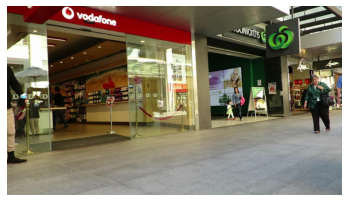

In [3]:
list_motdata = os.listdir(motdata)
list_motdata.sort()
print(motdata)
print(list_motdata[0])

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()

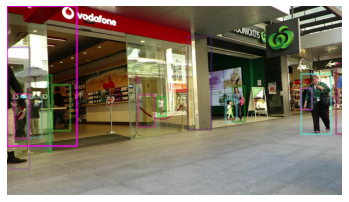

In [4]:
gt = open('./train/MOT17-09/gt/gt.txt', 'r')
frame_gt = []
unsegmented_image = img_ex.copy()

for gt_line in gt:
    frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z = gt_line.split(",")
    frame = int(frame)
    bb_id = int(bb_id)
    bb_left = int(bb_left)
    bb_top = int(bb_top)
    bb_width = int(bb_width)
    bb_height = int(bb_height)
    x = float(x)
    y = float(y)
    z = float(z)
    
    if frame == 1:
        overlay = unsegmented_image.copy()
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        alpha = 0.7
        
        frame_gt.append((frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z, color))
        
        pt1=(bb_left,bb_top)
        pt2=(bb_left+bb_width,bb_top+bb_height)
        cv2.rectangle(overlay, pt1 , pt2 , color, thickness = 10)
        unsegmented_image = cv2.addWeighted(overlay, alpha, unsegmented_image, 1 - alpha, 0)
        
# test rectangle
cv2.rectangle(unsegmented_image, (0,0) , (400,  800) , (255,0,255), thickness = 10)
unsegmented_image = cv2.addWeighted(unsegmented_image, alpha, img_ex, 1 - alpha, 0)
        
plt.imshow(unsegmented_image)
plt.axis('off')
plt.show()
#         cv.rectangle(img_ex, (int(boundRect[i][0]), int(boundRect[i][1])), \
#           (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
gt.close()

In [5]:
img_ex.shape
# print(frame_gt)

(1080, 1920, 3)

In [6]:
def getGrid(i, j, y_size, x_size):
    return (int(i * x_size), int(j * y_size)), (int((i+1) * x_size), int((j+1) * y_size))
#     return (int(j * y_size), int(i * x_size)), (int((j+1) * y_size), int((i+1) * x_size))

def getTLandBR(l, t, w, h):
    tl=(l,t) #x, y
    br=(l+w,t+h)
    return(tl, br)

def isPointInGrid(point, grid_top_left, grid_bottom_right):
    grid_top_left_y, grid_top_left_x = grid_top_left
    grid_bottom_right_y, grid_bottom_right_x = grid_bottom_right
    return (grid_top_left_x<=point[0] and grid_top_left_y<=point[1]) and \
                (grid_bottom_right_x>=point[0] and grid_bottom_right_y>=point[1])

def segment(frame, gt_bb, new_dim=(2, 2)):
    y_size = frame.shape[0]/new_dim[0]
    x_size = frame.shape[1]/new_dim[1]
    
    new_bb = []
    
    for bb in gt_bb: 
        print(bb)
        frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z, color = bb
        bb_tl, bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
        
        start_grid = None
        end_grid = None
        for i in range(0, new_dim[0]):
            for j in range(0, new_dim[1]):
                grid_top_left, grid_bottom_right = getGrid(i, j, y_size, x_size)
                grid_top_left_y, grid_top_left_x = grid_top_left
                grid_bottom_right_y, grid_bottom_right_x = grid_bottom_right
                
                if (isPointInGrid(bb_tl, grid_top_left, grid_bottom_right)):
                    start_grid = grid_top_left
                    
                if (isPointInGrid(bb_br, grid_top_left, grid_bottom_right)):
                    end_grid = grid_top_left
        
        ## TODO: normalize all bounding boxes outisde of res size
        if start_grid == None or end_grid == None:
            print("start and end box not detected")
        
        if start_grid != None and end_grid != None:
            tl_point = bb_tl
            bl_point = (bb_br[0], bb_tl[1]) #pink
            tr_point = (bb_tl[0], bb_br[1]) #cyan
            br_point = bb_br
            
            if start_grid == end_grid:
                new_bb.append((bb, (tl_point, bl_point, tr_point, br_point)))
                print("square start and ends in the same grid")
            else: 
                print("segmenting bb")
                x_units = (end_grid[1] - start_grid[1]) / x_size
                y_units = (end_grid[0] - start_grid[0]) / y_size
                
                for i in range(0, new_dim[0]):
                    for j in range(0, new_dim[1]):
                        grid_top_left, grid_bottom_right = getGrid(i, j, y_size, x_size)
                        segmented_bb = None
                        
                        if (isPointInGrid(tl_point, grid_top_left, grid_bottom_right)):
                            segment_bb_in_grid = list(bb_br)
                            if (x_units == 0):
                                segment_bb_in_grid[1] = grid_bottom_right[0]
                            if (y_units == 0):
                                segment_bb_in_grid[0] = grid_bottom_right[1]
                            if (x_units > 0 and y_units > 0):
                                segment_bb_in_grid = grid_bottom_right
                            segmented_bb = (bb_tl, tuple(segment_bb_in_grid))
                        elif (isPointInGrid(br_point, grid_top_left, grid_bottom_right)):
                            segment_bb_in_grid = list(bb_tl)
                            if (x_units == 0):
                                segment_bb_in_grid[1] = grid_top_left[0]
                            if (y_units == 0):
                                segment_bb_in_grid[0] = grid_top_left[1]
                            if (x_units > 0 and y_units > 0):
                                segment_bb_in_grid = grid_top_left
                            segmented_bb = (tuple(segment_bb_in_grid),  bb_br)
                        elif (isPointInGrid(bl_point, grid_top_left, grid_bottom_right) and (x_units > 0 and y_units > 0)):
                            segmented_bb = ((bl_point[0], grid_top_left[1]), (grid_bottom_right[0], bl_point[1]))
                            
#                             grid_top_right = (grid_top_left[0], grid_bottom_right[1])
#                             segment_bb_in_grid = list(tr_point)
#                             if (x_units == 0):
#                                 segment_bb_in_grid[1] = grid_top_right[0]
#                             if (y_units == 0):
#                                 segment_bb_in_grid[0] = grid_top_right[1]
#                             if (x_units > 0 and y_units > 0):
#                                 segment_bb_in_grid = grid_top_right
                                
#                             ## transform bl, tr to br, tl
#                             segmented_bb = ((bl_point[0], segment_bb_in_grid[1]), (segment_bb_in_grid[0], bl_point[1]))
                            print("bl_point")
                            print(segmented_bb)
                        elif (isPointInGrid(tr_point, grid_top_left, grid_bottom_right) and (x_units > 0 and y_units > 0)):
                            segmented_bb = ((grid_top_left[0], tr_point[1]), (tr_point[0], grid_bottom_right[1]))
                            print("tr_point")
                            print(segmented_bb)
                        
                        if (segmented_bb != None):
                            print("adding frame")
                            s_bb_tl = segmented_bb[0]
                            s_bb_br = segmented_bb[1]
                            s_w = s_bb_br[0] - s_bb_tl[0]
                            w_h = s_bb_br[1] - s_bb_tl[1]
                            new_bb.append(((frame, bb_id, s_bb_tl[0], s_bb_tl[1], s_w, w_h, x, y, z, color), (tl_point, bl_point, tr_point, br_point)))
                        else:
                            print("Skip")
    return new_bb

(1, 1, 260, 450, 102, 262, 1.0, 1.0, 1.0, (80, 191, 56))
(1, 19, 1686, 387, 171, 345, 1.0, 1.0, 1.0, (90, 238, 230))
(1, 20, 1886, 327, 156, 404, 1.0, 1.0, 0.22293, (158, 12, 86))
(1, 21, 1253, 533, 63, 129, 1.0, 1.0, 1.0, (118, 221, 236))
(1, 22, 1292, 459, 70, 202, 1.0, 1.0, 0.77624, (32, 129, 21))
(1, 23, -348, 235, 477, 695, 1.0, 1.0, 0.26987, (136, 88, 154))
(1, 25, 1035, 174, 136, 532, 0.0, 9.0, 1.0, (87, 38, 105))
(1, 26, 116, 522, 84, 230, 0.0, 8.0, 0.83529, (86, 158, 159))
(1, 27, 234, 395, 21, 440, 0.0, 9.0, 1.0, (18, 162, 50))
(1, 28, 1682, 470, 65, 122, 0.0, 8.0, 0.060606, (209, 102, 224))
(1, 30, 42, 502, 85, 254, 0.0, 8.0, 0.0, (208, 39, 162))
(1, 31, 863, 522, 46, 108, 0.0, 12.0, 1.0, (1, 200, 31))
(1, 44, 751, 506, 95, 182, 0.0, 12.0, 1.0, (184, 37, 130))
(1, 1, 260, 450, 102, 262, 1.0, 1.0, 1.0, (80, 191, 56))
square start and ends in the same grid
(1, 19, 1686, 387, 171, 345, 1.0, 1.0, 1.0, (90, 238, 230))
start and end box not detected
(1, 20, 1886, 327, 156, 404, 1.

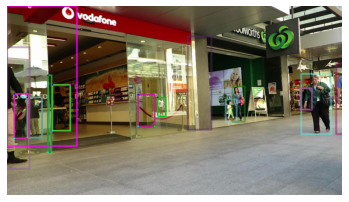

In [7]:
segmented_image = unsegmented_image.copy()
for frame in frame_gt:
    print(frame)
segmented_bbs = segment(segmented_image, frame_gt, new_dim=(2, 2))
for frame in segmented_bbs:
    print(frame)
for (segmented_bb, bb_points) in segmented_bbs:
    frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z, color = segmented_bb
    segmented_bb_tl, segmented_bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
    (tl_point, bl_point, tr_point, br_point) = bb_points
    
    cv2.rectangle(segmented_image, segmented_bb_tl, segmented_bb_br, color, thickness = 5)
    cv2.circle(segmented_image,tl_point, 4, (0,0,255), -1)
    cv2.circle(segmented_image,bl_point, 4, (255,0,255), -1)
    cv2.circle(segmented_image,tr_point, 4, (0,255,255), -1)
    cv2.circle(segmented_image,br_point, 4, (0,255,0), -1)

plt.imshow(segmented_image)
plt.axis('off')
plt.show()

In [8]:
def testRectForBB(gt_bbs, new_dim=(2, 2)):
    my_img_3 = np.zeros((100, 100, 3), dtype = "uint8")
    for gt_bb in gt_bbs:
        frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z, color = gt_bb
        bb_tl, bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)

        cv2.rectangle(my_img_3, bb_tl , bb_br , color, thickness = 5)
        my_img_3 = cv2.addWeighted(my_img_3, alpha, my_img_3, 1 - alpha, 0)

    segmented_bbs = segment(my_img_3, gt_bbs, new_dim)
#     print(segmented_bbs)
    for (segmented_bb, bb_points) in segmented_bbs:
#         print(segmented_bb)
        frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z, color = segmented_bb
        segmented_bb_tl, segmented_bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
        print((segmented_bb_tl, segmented_bb_br))
        (tl_point, bl_point, tr_point, br_point) = bb_points
        
        cv2.rectangle(my_img_3, segmented_bb_tl, segmented_bb_br, color, thickness = 5)
#         print(bb_points)
        cv2.circle(my_img_3,tl_point, 4, (0,0,255), -1)
        cv2.circle(my_img_3,bl_point, 4, (255,0,255), -1)
        cv2.circle(my_img_3,tr_point, 4, (0,255,255), -1)
        cv2.circle(my_img_3,br_point, 4, (0,255,0), -1)
    
    plt.imshow(my_img_3)
    plt.axis('off')
    plt.show()

(1, 1, 25, 25, 24, 24, 1.0, 1.0, 1.0, (77, 188, 95))
square start and ends in the same grid
((25, 25), (49, 49))


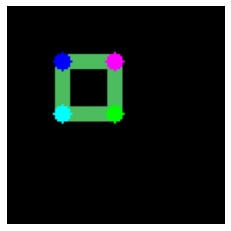

In [9]:
gt_bbs = [(1, 1, 25, 25, 24, 24, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs)

(1, 1, 15, 25, 50, 10, 1.0, 1.0, 1.0, (77, 188, 95))
segmenting bb
adding frame
adding frame
Skip
Skip
((15, 25), (50, 35))
((50, 25), (65, 35))


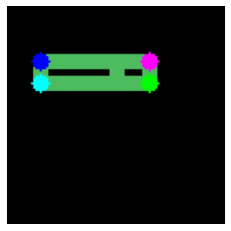

In [10]:
gt_bbs = [(1, 1, 15, 25, 50, 10, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs)

(1, 1, 25, 25, 10, 50, 1.0, 1.0, 1.0, (77, 188, 95))
segmenting bb
adding frame
Skip
adding frame
Skip
((25, 25), (35, 50))
((25, 50), (35, 75))


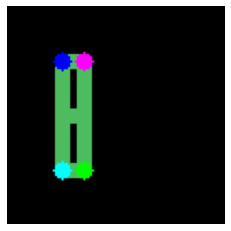

In [11]:
gt_bbs = [(1, 1, 25, 25, 10, 50, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs)

(1, 1, 25, 60, 50, 10, 1.0, 1.0, 1.0, (77, 188, 95))
segmenting bb
Skip
Skip
adding frame
adding frame
((25, 60), (50, 70))
((50, 60), (75, 70))


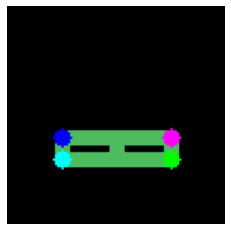

In [12]:
gt_bbs = [(1, 1, 25, 60, 50, 10, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs)

(1, 1, 60, 25, 10, 50, 1.0, 1.0, 1.0, (77, 188, 95))
segmenting bb
Skip
adding frame
Skip
adding frame
((60, 25), (70, 50))
((60, 50), (70, 75))


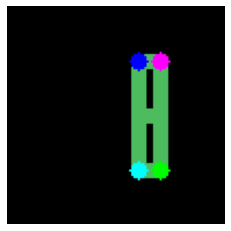

In [13]:
gt_bbs = [(1, 1, 60, 25, 10, 50, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs)

(1, 1, 15, 25, 70, 50, 1.0, 1.0, 1.0, (77, 188, 95))
segmenting bb
adding frame
bl_point
((85, 50), (50, 25))
adding frame
tr_point
((50, 75), (15, 50))
adding frame
adding frame
((15, 25), (50, 50))
((85, 50), (50, 25))
((50, 75), (15, 50))
((50, 50), (85, 75))


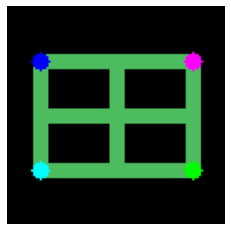

In [14]:
gt_bbs = [(1, 1, 15, 25, 70, 50, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs)

(1, 1, 15, 25, 70, 50, 1.0, 1.0, 1.0, (77, 188, 95))
segmenting bb
adding frame
Skip
bl_point
((85, 66), (33, 25))
adding frame
Skip
Skip
Skip
tr_point
((66, 75), (15, 33))
adding frame
Skip
adding frame
((15, 25), (33, 33))
((85, 66), (33, 25))
((66, 75), (15, 33))
((66, 66), (85, 75))


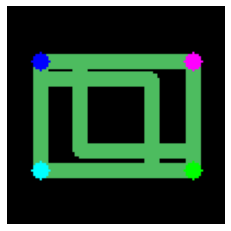

In [15]:
gt_bbs = [(1, 1, 15, 25, 70, 50, 1.0, 1.0, 1.0, (77, 188, 95))]
testRectForBB(gt_bbs, new_dim=(3, 3))

In [16]:
import Image

def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)
    
    segmented_bbs = segment(img, frame_gt, new_dim=(2, 2))
    for (segmented_bb, bb_points) in segmented_bbs:

IndentationError: expected an indented block (<ipython-input-16-3278c5acd20d>, line 15)